In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from time import time
import itertools
from matplotlib.ticker import NullFormatter
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm
import seaborn as sn

from sportsreference.nba.boxscore import Boxscore
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.schedule import Schedule
from sportsreference.nba.teams import Teams

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df_season = pd.read_csv('data/2nba_player_stats_by_season.csv')
df_career = pd.read_csv('data/2nba_player_stats_by_career.csv')

/home/luke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_career.head()

,id,and_ones,assist_percentage,assists,block_percentage,blocking_fouls,blocks,box_plus_minus,center_percentage,defensive_box_plus_minus,...,age,avg_salary,years_played,year_list,current_player,contract_total,contract_length,current_salary,current_avg_salary,current_team
0,bareajo01 Career,NaN,33.2,3270.0,0.1,NaN,24.0,-0.7,0,-1.4,...,NaN,2.795708e+06,14,"['2006-07', '2007-08', '2008-09', '2009-10', '...",False,NaN,NaN,NaN,NaN,NaN
1,broekry01 Career,NaN,7.5,33.0,1.1,NaN,8.0,-0.5,0,-0.3,...,NaN,1.127658e+06,2,"['2018-19', '2019-20']",False,NaN,NaN,NaN,NaN,NaN
2,brunsja01 Career,NaN,23.2,555.0,0.2,NaN,8.0,-1.0,0,-0.8,...,NaN,8.822840e+05,3,"['2018-19', '2019-20', '2020-21']",True,3465918.0,2.0,1663861.0,1732959.0,DAL
3,burketr01 Career,NaN,25.0,1447.0,0.4,NaN,48.0,-1.1,0,-1.6,...,NaN,1.983643e+06,8,"['2013-14', '2014-15', '2015-16', '2016-17', '...",True,9999999.0,3.0,3174603.0,3333333.0,DAL
4,caulewi01 Career,NaN,10.1,579.0,3.2,NaN,317.0,0.0,0,0.6,...,NaN,2.921326e+06,6,"['2015-16', '2016-17', '2017-18', '2018-19', '...",True,8200000.0,2.0,4000000.0,4100000.0,DAL


## Dropping columns with all null or useless values

In [4]:
for col in df_career.columns:
    unique = df_career[col].unique()
    val = len(unique)
    drop_lst = []
    if val < 20:
        drop_lst.append(str(col))
        print(f'{col}: has {val} values')
        print(f'Values include:')
        print(f'     {unique}')

print(f'Drop List: {drop_lst}')
# df_career['center_percentage'].unique()

and_ones: has 1 values
Values include:
     [nan]
blocking_fouls: has 1 values
Values include:
     [nan]
center_percentage: has 1 values
Values include:
     [0]
dunks: has 1 values
Values include:
     [nan]
half_court_heaves_made: has 7 values
Values include:
     [0. 1. 2. 3. 6. 4. 5.]
lost_ball_turnovers: has 1 values
Values include:
     [nan]
net_plus_minus: has 1 values
Values include:
     [nan]
offensive_fouls: has 1 values
Values include:
     [nan]
on_court_plus_minus: has 1 values
Values include:
     [nan]
other_turnovers: has 1 values
Values include:
     [nan]
passing_turnovers: has 1 values
Values include:
     [nan]
percentage_field_goals_as_dunks: has 1 values
Values include:
     [nan]
percentage_of_three_pointers_from_corner: has 1 values
Values include:
     [nan]
percentage_shots_three_pointers: has 1 values
Values include:
     [nan]
percentage_shots_two_pointers: has 1 values
Values include:
     [nan]
point_guard_percentage: has 1 values
Values include:
     [

In [5]:
nulls = ['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id']

In [6]:
df_career = df_career.drop(['and_ones', 'blocking_fouls', 'dunks', 'lost_ball_turnovers',
'net_plus_minus', 'offensive_fouls', 'on_court_plus_minus',
'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers',
'percentage_shots_two_pointers', 'points_generated_by_assists',
'shooting_fouls', 'shooting_fouls_drawn', 'shots_blocked',
'take_fouls', 'team_abbreviation', 'three_point_shot_percentage_from_corner',
'three_pointers_assisted_percentage', 'two_pointers_assisted_percentage',
'age', 'center_percentage', 'point_guard_percentage',
'power_forward_percentage', 'shooting_guard_percentage',
'small_forward_percentage', 'year', 'player_id'], axis=1)

## Dropping Rows(players)

In [7]:
# Also going to drop players that don't have any recorded salary
df_career = df_career.dropna(subset=['salary'])
# And players whos salary appeared as $0.0 for some reason
df_career = df_career[df_career['salary'] > 0]

In [8]:
# Double-checking that the double_names are actually unique players (Spoiler Alert: they are)
#double_names = ['Dee Brown', 'Marcus Williams', 'Chris Johnson', 'Mike James']
#df_career[df_career['name'].isin(double_names)]
name_counts = df_career.groupby('name')['name'].count()
name_counts.sort_values(ascending=False)

name
Dee Brown            2
Marcus Williams      2
Chris Johnson        2
Mike James           2
Fred Vinson          1
                    ..
Michael Dickerson    1
Michael Doleac       1
Michael Finley       1
Michael Frazier      1
A.C. Green           1
Name: name, Length: 1919, dtype: int64

In [9]:
# Setting index to the Players name & modifying the ID's so that they don't have 'Career appended for some reason'
df_career['id'] = df_career['id'].str.split(' ').str[0]
df_career = df_career.set_index('name')

In [10]:
def to_inches(height):
    feet, inches = str(height).split('-')
    return (int(feet)*12) + int(inches)

In [11]:
df_career['height'] = df_career['height'].apply(to_inches)

In [12]:
df_career['height']

name
J.J. Barea             70
Ryan Broekhoff         78
Jalen Brunson          73
Trey Burke             72
Willie Cauley-Stein    84
                       ..
Eric Murdock           73
Chris Anstey           84
B.J. Armstrong         74
Khalid Reeves          75
Dedric Willoughby      75
Name: height, Length: 1923, dtype: int64

In [13]:
player_ids = df_career['id'].values
player_ids

array(['bareajo01', 'broekry01', 'brunsja01', ..., 'armstbj01',
       'reevekh01', 'willode01'], dtype=object)

In [14]:
player_names = df_career.index.values
player_names

array(['J.J. Barea', 'Ryan Broekhoff', 'Jalen Brunson', ...,
       'B.J. Armstrong', 'Khalid Reeves', 'Dedric Willoughby'],
      dtype=object)

## Filling NaNs

In [15]:
# Grabbing players that are not currently assigned positions
unpositioned_players = df_career[df_career['position'].isna()]
#unpositioned_players

In [16]:
# Filling nan for position with 'na' & then the rest of the categories with 0's
# because they're only nan's since they haven't attempted
df_career['position'] = df_career['position'].fillna('na')
df_career = df_career.fillna(0)

In [17]:
# Creating current/past players DF's & then dropping the columns that only pertain to current players from career_df
df_past_players = df_career[df_career['current_player'] == False]
#df_past_players
df_current_players = df_career[df_career['current_player'] == True]
#df_current_players
current_player_features = ['contract_total', 'contract_length', 'current_salary', 'current_avg_salary', 'current_team']
df_career = df_career.drop(current_player_features, axis=1)

In [18]:
# Creating seperate DFs for different use cases
df_career_no_salaries = df_career.drop(['salary'], axis=1)

non_stats = ['nationality', 'position', 'birth_date', 'year_list', 'id']

df_pure_stats = df_career.drop(non_stats, axis=1)
df_pure_stats_no_salary = df_pure_stats.drop(['salary'], axis=1)

In [19]:
df_pure_stats['current_player'] = df_pure_stats['current_player'].astype(int)

In [20]:
# Creating DF that only contains stats that are already averaged

avgs = ['assist_percentage', 'avg_salary', 'block_percentage', 'box_plus_minus',
'defensive_box_plus_minus', 'defensive_rebound_percentage', 'effective_field_goal_percentage',
'field_goal_percentage', 'field_goal_perc_sixteen_foot_plus_two_pointers',
'field_goal_perc_ten_to_sixteen_feet', 'field_goal_perc_three_to_ten_feet',
'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
'free_throw_attempt_rate', 'free_throw_percentage', 'offensive_box_plus_minus',
'offensive_rebound_percentage', 'player_efficiency_rating',
'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage',
'turnover_percentage', 'two_point_percentage', 'usage_percentage',
'win_shares', 'win_shares_per_48_minutes', 'years_played']

df_avgs = df_pure_stats[['assist_percentage', 'avg_salary', 'block_percentage', 'box_plus_minus',
'defensive_box_plus_minus', 'defensive_rebound_percentage', 'effective_field_goal_percentage',
'field_goal_percentage', 'field_goal_perc_sixteen_foot_plus_two_pointers',
'field_goal_perc_ten_to_sixteen_feet', 'field_goal_perc_three_to_ten_feet',
'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
'free_throw_attempt_rate', 'free_throw_percentage', 'offensive_box_plus_minus',
'offensive_rebound_percentage', 'player_efficiency_rating',
'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage',
'turnover_percentage', 'two_point_percentage', 'usage_percentage',
'win_shares', 'win_shares_per_48_minutes', 'years_played']]
#df_avgs.head()

In [21]:
df_totals = df_pure_stats.drop(avgs, axis=1)

## Sanity check before modeling

In [22]:
df_pure_stats.columns

Index(['assist_percentage', 'assists', 'block_percentage', 'blocks',
       'box_plus_minus', 'defensive_box_plus_minus',
       'defensive_rebound_percentage', 'defensive_rebounds',
       'defensive_win_shares', 'effective_field_goal_percentage',
       'field_goal_attempts', 'field_goal_perc_sixteen_foot_plus_two_pointers',
       'field_goal_perc_ten_to_sixteen_feet',
       'field_goal_perc_three_to_ten_feet',
       'field_goal_perc_zero_to_three_feet', 'field_goal_percentage',
       'field_goals', 'free_throw_attempt_rate', 'free_throw_attempts',
       'free_throw_percentage', 'free_throws', 'games_played', 'games_started',
       'half_court_heaves', 'half_court_heaves_made', 'height',
       'minutes_played', 'offensive_box_plus_minus',
       'offensive_rebound_percentage', 'offensive_rebounds',
       'offensive_win_shares', 'percentage_sixteen_foot_plus_two_pointers',
       'percentage_ten_to_sixteen_footers', 'percentage_three_to_ten_footers',
       'percentage_zero_to

In [23]:
df_totals.head()

,assists,blocks,defensive_rebounds,defensive_win_shares,field_goal_attempts,field_goals,free_throw_attempts,free_throws,games_played,games_started,...,three_point_attempt_rate,three_point_attempts,three_pointers,total_rebounds,turnovers,two_point_attempts,two_pointers,value_over_replacement_player,weight,current_player
name,,,,,,,,,,,,,,,,,,,,,
J.J. Barea,3270.0,24.0,1495.0,10.1,6685.0,2832.0,1174.0,932.0,831.0,107.0,...,0.349,2330.0,819.0,1748.0,1264.0,4355.0,2013.0,5.3,180,0
Ryan Broekhoff,33.0,8.0,93.0,0.5,185.0,79.0,27.0,22.0,59.0,1.0,...,0.778,144.0,58.0,106.0,22.0,41.0,21.0,0.2,215,0
Jalen Brunson,555.0,8.0,386.0,2.2,1314.0,636.0,297.0,229.0,171.0,64.0,...,0.324,426.0,155.0,446.0,210.0,888.0,481.0,0.9,190,1
Trey Burke,1447.0,48.0,678.0,4.6,4181.0,1724.0,617.0,496.0,438.0,129.0,...,0.362,1514.0,526.0,833.0,520.0,2667.0,1198.0,2.1,185,1
Willie Cauley-Stein,579.0,317.0,1689.0,10.1,2763.0,1500.0,893.0,548.0,384.0,249.0,...,0.010,27.0,5.0,2344.0,364.0,2736.0,1495.0,4.4,240,1


In [40]:
df_avgs.shape

(1923, 27)

In [69]:
range(2,16)

range(2, 16)

# Modeling Section

In [95]:
def find_best_cluster_amount(x, comps, loops):
    d = {}
    for i in range(loops):
        # Fits data to a new array using PCA given the number of components passed through comp parameter
        after_pca = PCA(n_components=comps,whiten=True).fit_transform(x)
        
        k_range = range(2,16) # Range of amount of clusters I might expect to see
        
        # Doing KMeans clustering on the range chosen in k_range
        k_means_var = [KMeans(n_clusters=k).fit(after_pca) for k in k_range]
        
        # Capturing labels for KMeans_var
        labels = [i.labels_ for i in k_means_var]
        
        # Calculating silhouette score at each label
        sil_score = [silhouette_score(after_pca, i, metric='euclidean') for i in labels]
        
        # Generates list of points where center of clusters are
        centroids = [i.cluster_centers_ for i in k_means_var]
        
        # Calculates distance between newly generated data and the centroids found in KMeans
        k_euclid = [cdist(after_pca,cent,'euclidean') for cent in centroids]
        
        dist = [np.min(ke, axis=1) for ke in k_euclid]
        wcss = [sum(d**2) for d in dist]
        tss = sum(pdist(after_pca)**2/after_pca.shape[0])
        bss = tss - wcss
        
        sil_arr = np.transpose(sil_score)*100
        max_score = np.max(sil_arr)
        max_score_index = np.argmax(sil_arr == max_score)
        
        if max_score_index in d:
            d[max_score_index] += 1
        else:
            d[max_score_index] = 1
    
    return d

In [55]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [93]:
# Silhouette Graphing:

""" 
    X = x
    range_n_clusters = range(2,10)
 """

def silhouette_graph(X, range_n_clusters):
    # taken from sklearn
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap('Spectral')
            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        colors = cmap(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

        plt.show()

## Normalizing with MinMaxScalar

In [47]:
x = df_avgs.values
x.shape

(1923, 27)

In [71]:
x = df_avgs.values
min_max_scalar = MinMaxScaler()
x_scaled = min_max_scalar.fit_transform(x)
df_avgs_normalized = pd.DataFrame(x_scaled)

array([[0.42292994, 0.1621515 , 0.00380228, ..., 0.10459393, 0.62423959,
        0.61904762],
       [0.0955414 , 0.06531775, 0.0418251 , ..., 0.011895  , 0.63500234,
        0.04761905],
       [0.2955414 , 0.05107328, 0.00760456, ..., 0.03773585, 0.63781001,
        0.0952381 ],
       ...,
       [0.26624204, 0.08629967, 0.00760456, ..., 0.19155045, 0.64810482,
        0.47619048],
       [0.30955414, 0.08706174, 0.01520913, ..., 0.0414274 , 0.62377164,
        0.23809524],
       [0.3133758 , 0.00768934, 0.01140684, ..., 0.00861362, 0.61020122,
        0.        ]])

In [49]:
x = df_avgs_normalized.values
x.shape[1]

27

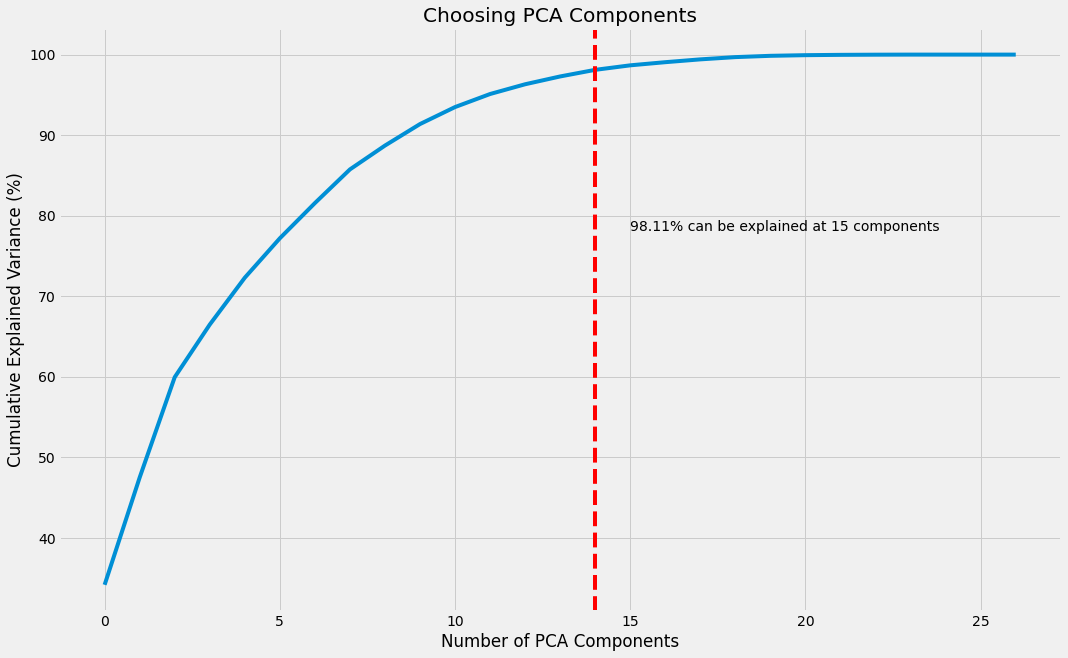

In [50]:
pca = PCA(x.shape[1])
pca.fit(x)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var_to_beat = np.argwhere(var1 >= 98)
var_explained = np.round(var1[var_to_beat[0]], decimals=2)[0]
comps = var_to_beat.flatten()[1]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(var1)
ax.set_title('Choosing PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.axvline(var_to_beat[0], c='r', linestyle='--')
ax.annotate(f'{var_explained}% can be explained at {comps} components', xy=(comps, var_explained-20))

plt.savefig('images/pca_scree_minmax.png')

In [75]:
d_clusters = find_best_cluster_amount(x, comps, 250)
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))
print(d_clusters)
print(f'Number of Clusters in order from best to worst: {d_clusters.keys()}')

{2: 12, 1: 8, 7: 5, 0: 5, 13: 4, 12: 4, 3: 3, 5: 2, 9: 2, 10: 1, 4: 1, 8: 1, 6: 1, 11: 1}
Number of Clusters in order from best to worst: dict_keys([2, 1, 7, 0, 13, 12, 3, 5, 9, 10, 4, 8, 6, 11])


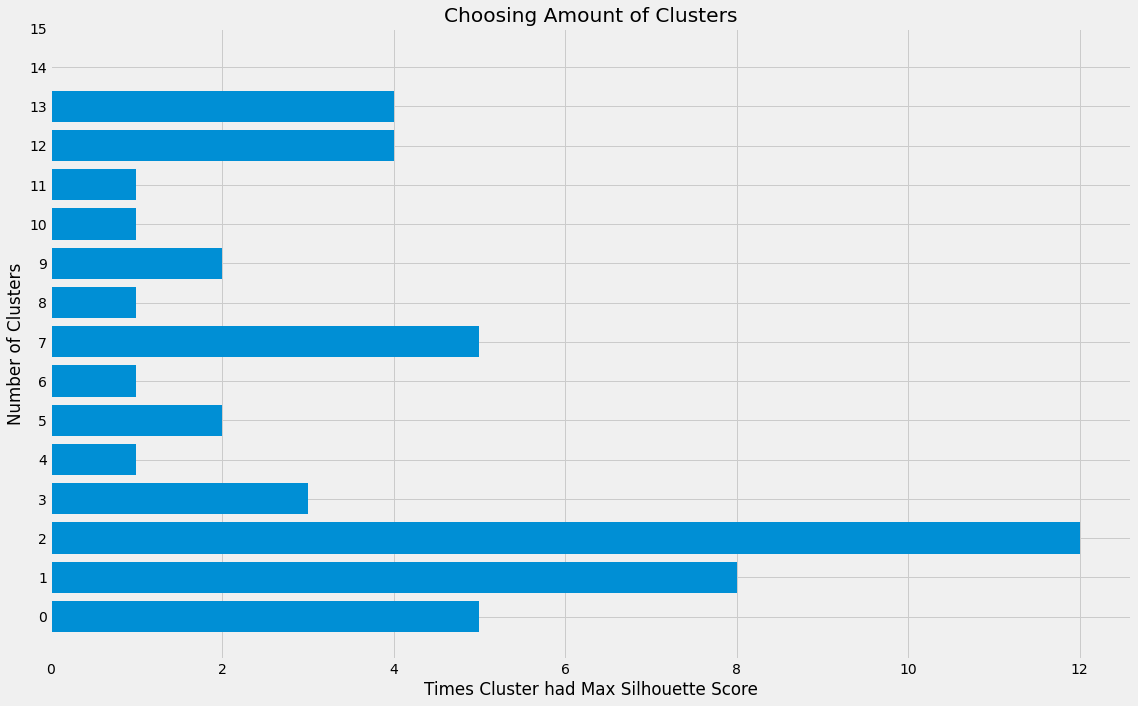

In [76]:
# Plotting Clusters
fig, ax = plt.subplots(figsize=(16,10))

ax.barh(list(d_clusters.keys()), list(d_clusters.values()))
ax.set_title('Choosing Amount of Clusters')
ax.set_xlabel('Times Cluster had Max Silhouette Score')
ax.set_ylabel('Number of Clusters')
ax.set_yticks(np.arange(16))

fig = ax.figure
fig.set_size_inches(16,10)
fig.tight_layout(pad=1)
fig.savefig('images/number_of_clusters_minmax.png')

## Normalizing with Standard Scalar

In [82]:
x = df_avgs.values
x.shape

(1923, 27)

In [83]:
x = df_avgs.values
standard_scalar = StandardScaler()
x_scaled = standard_scalar.fit_transform(x)
df_avgs_normalized = pd.DataFrame(x_scaled)
x = df_avgs_normalized.values
x.shape[1]

27

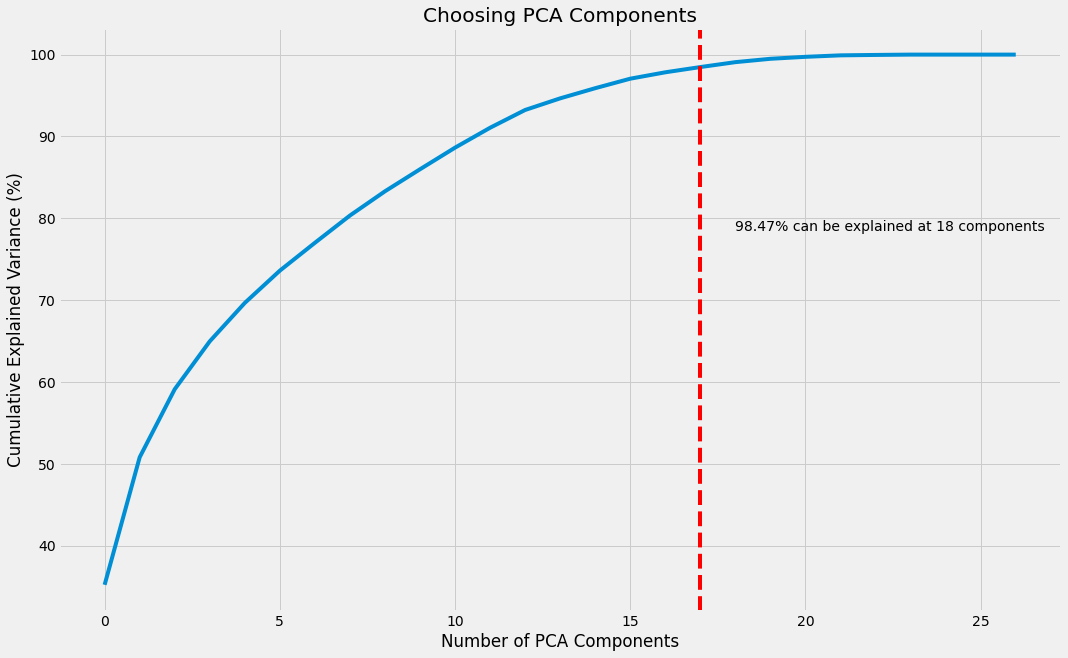

In [84]:
pca = PCA(x.shape[1])
pca.fit(x)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var_to_beat = np.argwhere(var1 >= 98)
var_explained = np.round(var1[var_to_beat[0]], decimals=2)[0]
comps = var_to_beat.flatten()[1]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(var1)
ax.set_title('Choosing PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Cumulative Explained Variance (%)')
ax.axvline(var_to_beat[0], c='r', linestyle='--')
ax.annotate(f'{var_explained}% can be explained at {comps} components', xy=(comps, var_explained-20))

plt.savefig('images/pca_scree_standard.png')

## Finding best cluster amounts

Text(0, 0.5, 'Average Silhouette Score')

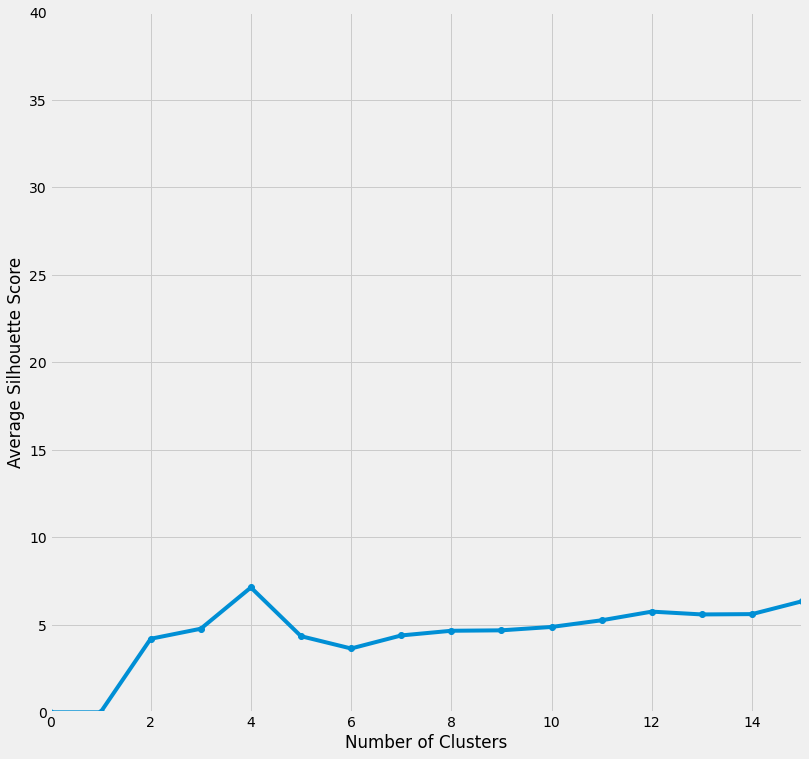

In [92]:
d_clusters = find_best_cluster_amount(x, comps, 250)
d_clusters = dict(sorted(d_clusters.items(), key=lambda item: item[1], reverse=True))
print(d_clusters)
print(f'Number of Clusters in order from best to worst: {d_clusters.keys()}')

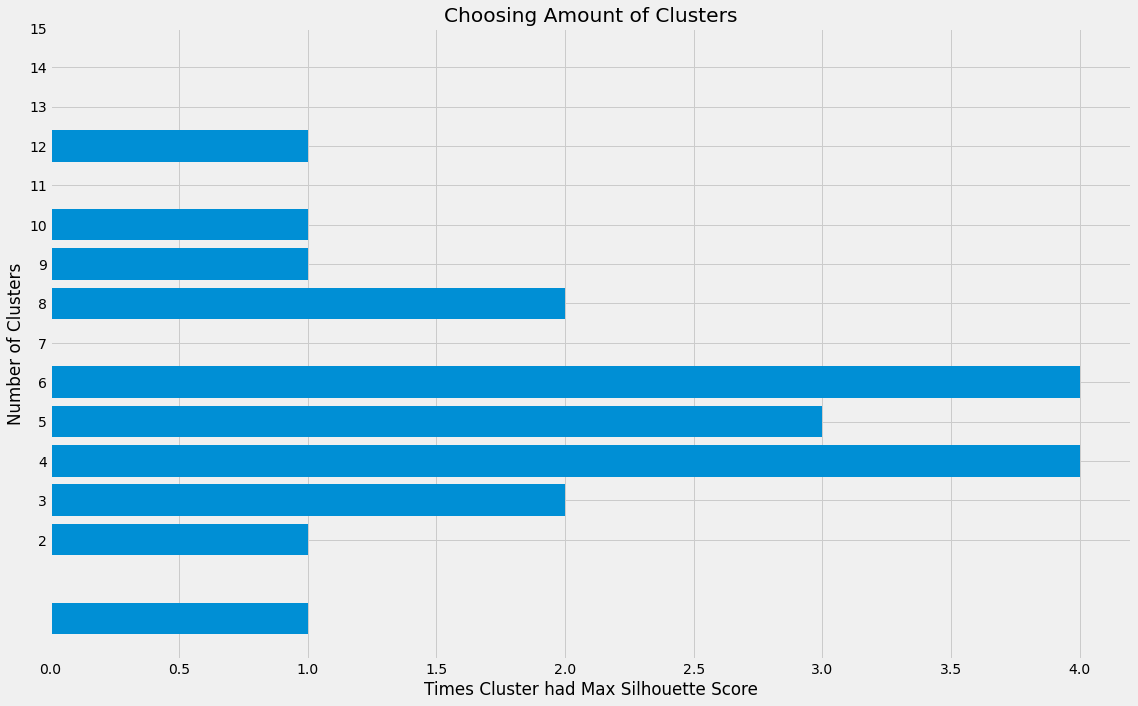

In [36]:
# Plotting Clusters
fig, ax = plt.subplots(figsize=(16,10))

ax.barh(list(d_clusters.keys()), list(d_clusters.values()))
ax.set_title('Choosing Amount of Clusters')
ax.set_xlabel('Times Cluster had Max Silhouette Score')
ax.set_ylabel('Number of Clusters')
ax.set_yticks(np.arange(2,16))

fig = ax.figure
fig.set_size_inches(16,10)
fig.tight_layout(pad=1)
fig.savefig('images/number_of_clusters_standard.png')

In [ ]:
silhouette_graph(x, range(2,16))

## TSNE

In [37]:
# Trying TSNE
x_embedded = TSNE().fit_transform(x)
x_embedded.shape

(1923, 2)

perplexity=5 in 4.6 sec
perplexity=30 in 5.6 sec
perplexity=50 in 6.6 sec
perplexity=100 in 9.2 sec


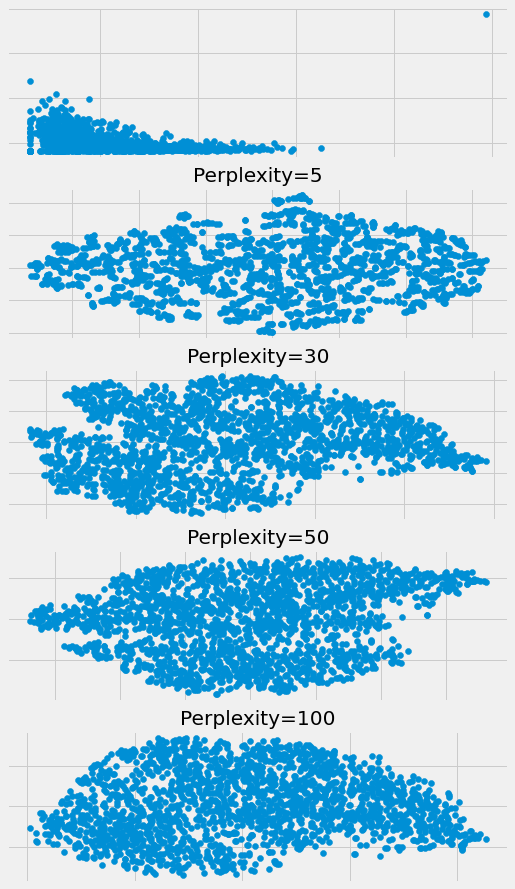

In [38]:
(fig, subplots) = plt.subplots(5, figsize=(8, 15))
n_components = 2
perplexities = [5, 30, 50, 100]

ax = subplots[0]
ax.scatter(x[:, 0], x[:, 2])
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(x)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')